# Classificação em aprendizado de máquina supervisionado com geometria computacional
    Gabriel Lima Barros - 2020006531
    Gabriel Teixeira Carvalho - 2020006558
    Thiago Pádua de Carvalho - 2020007066

Este trabalho lida com o problema de implementar um classificador utilizando aprendizado de máquina supervisionado. 

O objetivo principal desta tarefa é criar um programa que, dado um conjunto de dados com 2 colunas de atributos e 1 coluna de classe, consiga classificar novos dados em uma das duas classes disponíveis. 

Para resolver o problema citado, foram utilizados algoritmos de geometria computacional aprendidos na disciplina de Algoritmos II.

Ao longo deste notebook, serão apresentadas as implementações dos algoritmos utilizados para a solução do problema. Além disso, serão apresentados os resultados obtidos com a execução do programa, utilizando métricas comuns em aprendizado de máquina. Por fim, serão apresentadas as conclusões (e possíveis melhorias para o programa)?.

### Importando as bibliotecas

In [78]:
from random import random, choice
from functools import cmp_to_key
from bintrees import RBTree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

### Implementação do Graham Scan (Envoltória Convexa)

Primeiro, definimos uma classe que representa um ponto no plano cartesiano. Essa classe possui os atributos x e y, que representam as coordenadas do ponto.

In [79]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.isLeftEndpoint = False
    self.segmentId = None
  
  def __str__(self):
    return "(" + str(self.x) + ", " + str(self.y) + ")"

def printPointList(points):
  for p in points:
    print(p, end=" ")
  print()

Definimos uma função que calcula a orientação de três pontos. Essa função recebe três pontos (p0, p1 e p2) e retorna uma string representando a orientação dos segmentos *p0-p1* e *p0-p2*. Se a orientação for "left", então os três pontos estão em sentido anti-horário. Se a orientação for "right", então os três pontos estão em sentido horário. Se a orientação for "collinear", então os três pontos estão colineares.

In [80]:
def findOrientation(p0, p1, p2):
  crossProduct = (p1.x - p0.x) * (p2.y - p0.y) - (p2.x - p0.x) * (p1.y - p0.y)
  if crossProduct == 0:
    return "collinear"
  elif crossProduct > 0:
    return "right"
  else:
    return "left"

Definimos uma função que encontra o ponto com menor coordenada y. Essa função recebe um conjunto de pontos e retorna o ponto com menor coordenada y. Caso haja mais de um ponto com a menor coordenada y, então o ponto com menor coordenada x é retornado.

In [81]:
def findBottomMostPoint(points):
  bottomMostPoint = points[0]

  for p in points:
    if p.y < bottomMostPoint.y or (p.y == bottomMostPoint.y and p.x < bottomMostPoint.x):
      bottomMostPoint = p

  return bottomMostPoint

Definimos uma função que ordena os pontos de um conjunto de pontos. Essa função recebe um conjunto de pontos e retorna uma lista de pontos ordenados em ordem.

In [82]:
def findDistance(p0, p1):
  return ((p1.x - p0.x) ** 2 + (p1.y - p0.y) ** 2) ** 0.5

def sortPoints(points, bottomMostPoint):
  def comparePolarAngle(p1, p2):
    orientation = findOrientation(bottomMostPoint, p1, p2)
    if orientation == "collinear":
      if findDistance(bottomMostPoint, p1) <= findDistance(bottomMostPoint, p2):
        return -1
      else:
        return 1
    elif orientation == "right":
      return -1
    else:
      return 1
  sortedPoints = sorted(points, key = cmp_to_key(comparePolarAngle))
  return sortedPoints

def removeCollinearPoints(sortedPoints,bottomMostPoint):
  i = 0
  while i < len(sortedPoints) - 1:
    if findOrientation(bottomMostPoint, sortedPoints[i], sortedPoints[i + 1]) == "collinear":
      sortedPoints.pop(i)
    else:
      i += 1

Definimos uma função que retorna os pontos de um conjunto que formam a envoltória convexa desse conjunto. Para isso foi usado o algoritmo da Varredura de Graham.

In [83]:
def findConvexHull(points):
    bottomMostPoint = findBottomMostPoint(points)
    points.remove(bottomMostPoint)
    sortedPoints = sortPoints(points, bottomMostPoint)
    removeCollinearPoints(sortedPoints, bottomMostPoint)
    sortedPoints = [bottomMostPoint] + sortedPoints

    if len(sortedPoints) < 3:
      print("Convex hull is not possible!")

    convexHull = [sortedPoints[0], sortedPoints[1], sortedPoints[2]]
    for i in range(3, len(sortedPoints)):
        while findOrientation(convexHull[-2], convexHull[-1], sortedPoints[i]) != "right":
            convexHull.pop()
        convexHull.append(sortedPoints[i])
    return convexHull

### Implementação Interceptação de Segmentos entre Conjuntos
Uma vez que temos os pontos que fazem parte da envoltória convexa precisamos transformá-los em segmentos, para isso foi definida uma classe para representar segmetos em um plano cartesiano e uma função que recebe os pontos que fazem parte de uma envoltória convexa e retorna os segmentos que limitam essa envoltória. Dentro da classe sobrescrevemos alguns operadores para possibilitar a inserção na árvore vermelho e preto, posteriormente, dessa forma os segmentos serão avaliados de acordo com a altura que ele se encontra no plano em comparação com os outros segmentos da árvore.

In [84]:
class Segment:
    def __init__(self, id, p1, p2, convexHullLabel):
        if p1.x < p2.x:
            self.p1 = Point(p1.x, p1.y)
            self.p2 = Point(p2.x, p2.y)
        else:
            self.p1 = Point(p2.x, p2.y)
            self.p2 = Point(p1.x, p1.y)
        self.p1.isLeftEndpoint = True
        self.p1.segmentId = id
        self.p2.segmentId = id
        self.convexHullLabel = convexHullLabel

    def __str__(self):
        return "(" + str(self.p1.x) + ", " + str(self.p1.y) + ", " + str(self.p1.isLeftEndpoint) + ") - (" + str(self.p2.x) + ", " + str(self.p2.y) + ", " + str(self.p2.isLeftEndpoint)+ ")" + " " + self.convexHullLabel
    
    # return if a segment is below another
    def __gt__(self, other):
        if (min(self.p1.x,other.p1.x)==self.p1.x):
                b = self
                a = other
        else:
            b = other
            a = self
        m2 = (b.p2.y - b.p1.y)/(b.p2.x - b.p1.x)
        m1 = (a.p2.y - a.p1.y)/(a.p2.x - a.p1.x)

        x0 = max(self.p1.x,other.p1.x)
        if not (segmentsIntersect(self.p1,self.p2, other.p1,other.p2)):
            if (findOrientation(b.p1, a.p1, b.p2) == 'right'):
                return True if b == self else False
            elif (findOrientation(b.p1, a.p1, b.p2) == 'left'):
                return False if b == self else True
        else:
            if b.p1.y - m2 * b.p1.x - a.p1.y + m1 * a.p1.x < (m1-m2) * x0:
                return True if b == self else False
            else:
                return False if b == self else True

def printSegments(segments):
    print()
    for segment in segments:
        print(segment)

def findSegments(convexHull, convexHullLabel):
    segments = []
    for i in range(len(convexHull) - 1):
        point1 = convexHull[i]
        point2 = convexHull[i + 1]
        segment = Segment(i, point1, point2, convexHullLabel)
        segments.append(segment)
    point1 = convexHull[-1]
    point2 = convexHull[0]
    segmentId = len(convexHull) - 1
    segments.append(Segment(segmentId, point1, point2, convexHullLabel))
    
    return segments

Com o intuito de auxiliar na varredura linear, definimos funções que checam se existem segmentos que se interceptam, utilizamos o algoritmo padrão para checar se segmentos se interceptam utilizando a função "findOrientation" e a função "onSegment" para checar se um ponto de um segmento fazia parte do outro.

In [85]:
def onSegment(p1, p2, p3):
    if ((p3.x <= p2.x and p3.x >= p1.x) or (p3.x <= p1.x and p3.x >= p2.x)):
        if ((p3.y <= p2.y and p3.y >= p1.y) or (p3.y <= p1.y and p3.y >= p2.y)):
            return True
    return False

def segmentsIntersect(p1, p2, p3, p4):
    d1 = findOrientation(p3, p4, p1)
    d2 = findOrientation(p3, p4, p2)
    d3 = findOrientation(p1, p2, p3)
    d4 = findOrientation(p1, p2, p4)

    if ((d1 == 'right' and d2 == 'left') or (d1 == 'left' and d2 == 'right')) and ((d3 == 'right' and d4 == 'left') or (d3 == 'left' and d4 == 'right')): 
        return True
    elif d1 == 'collinear'and onSegment(p3,p4,p1):
        return True
    elif d2 == 'collinear'and onSegment(p3,p4,p2):
        return True
    elif d3 == 'collinear'and onSegment(p1,p2,p3):
        return True
    elif d4 == 'collinear'and onSegment(p1,p2,p4):
        return True
    else:
        return False

Definimos funções para encontrar e ordenar os pontos finais dos segmentos da envoltória tendo o ponto final à esquerda precedência sobre o ponto final a direita.

In [86]:
def findSegmentsEndpoints(segments):
    endpoints = []
    for segment in segments:
        leftEndpoint = segment.p1
        rightEndpoint = segment.p2

        endpoints.append(leftEndpoint)
        endpoints.append(rightEndpoint)
    return endpoints

def sortEndpoints(endpoints):
    def compareEndpoints(p1, p2):
        if p1.x < p2.x:
            return -1
        elif p1.x > p2.x:
            return 1
        else:
            if p1.isLeftEndpoint and not p2.isLeftEndpoint:
                return -1
            elif not p1.isLeftEndpoint and p2.isLeftEndpoint:
                return 1
            else:
                if p1.y < p2.y:
                    return -1
                elif p1.y > p2.y:
                    return 1
                else:
                    return 0
    sortedEndpoints = sorted(endpoints, key = cmp_to_key(compareEndpoints))
    return sortedEndpoints

Definimos identificadores para os segmentos para que seja possível encontrarmos os segmentos a partir do seu ponto final em tempo constante.

In [87]:
def adjustBSegmentsId(segmentsB, segmentsA):
    for segment in segmentsB:
        segment.p1.segmentId += len(segmentsA)
        segment.p2.segmentId += len(segmentsA)

Fizemos perturbações nos pontos para evitar a inserção de pontos iguais e retas verticais

In [88]:
def perturbateSegments(segments):
    for segment in segments:
        segment.p1.x += random() * 0.000001
        segment.p2.x += random() * 0.000001
    return segments

Dessa forma, definimos a função para determinar se há interseção entre segmentos de duas envoltórias diferentes, para isso utilizamos o algoritmo que determina se há interseção entre segmentos dentro de um conjunto e adaptamos, adicionando rótulos aos segmentos para definir à qual envoltória eles pertenciam, se fossem da mesma a interseção era ignorada, mas se fossem de envoltórias diferentes então deveria ser retornada a existência de uma interseção.

In [89]:
def anySegmentsIntersectTree(convexHullA, convexHullB):
    tree = RBTree()
    AHullSegments = findSegments(convexHullA, "A")
    BHullSegments = findSegments(convexHullB, "B")
    adjustBSegmentsId(BHullSegments, AHullSegments)
    allSegments = perturbateSegments(AHullSegments + BHullSegments)
    allEndpoints = findSegmentsEndpoints(allSegments)
    sortedEndpoints = sortEndpoints(allEndpoints)

    for endpoint in sortedEndpoints:
        if endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            tree.insert(segment, endpoint.segmentId)
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (segment.convexHullLabel != segmentBelow.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentBelow.p1, segmentBelow.p2)):
                    return True
            if (tree.max_key() != segment):
                segmentAbove = tree.succ_key(segment)
                if (segment.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentAbove.p1, segmentAbove.p2)):
                    return True
        if not endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (tree.max_key() != segment):
                    segmentAbove = tree.succ_key(segment)
                    if (segmentBelow.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segmentBelow.p1, segmentBelow.p2, segmentAbove.p1, segmentAbove.p2)):
                        return True
            tree.remove(segment)
    return False

In [90]:
def contains(p,convexHull):
    crossings = 0
    for i in range(len(convexHull)-1):
        slope = (convexHull[i+1].y - convexHull[i].y)/(convexHull[i+1].x - convexHull[i].x)
        cond1 = (convexHull[i].x <= p.x) and (p.x < convexHull[i+1].x)
        cond2 = (convexHull[i+1].x <= p.x) and (p.x < convexHull[i].x)
        above = (p.y < slope *(p.x - convexHull[i].x) + convexHull[i].y)
        if ((cond1 or cond2) and above ):
            crossings += 1
    return crossings % 2 != 0

O próximo passo foi traçar a reta que separa as duas envoltórias, para isso criamos uma função que encontra o par de pontos mais próximo entre as envoltórias e calculamos a reta mediatriz do segmento formado por esses dois pontos. Essa reta intercepta o segmento formado pelos dois pontos de forma perpendicular, separando os pontos se não houver interseção.

In [91]:
def findClosestPairOfPoints(convexHullA, convexHullB):
    closestDistance = float("inf")
    closestPair = None
    for i in range(len(convexHullA)):
        for j in range(len(convexHullB)):
            distance = findDistance(convexHullA[i], convexHullB[j])
            if distance < closestDistance:
                closestDistance = distance
                closestPair = Segment("", convexHullA[i], convexHullB[j], "")
    return closestPair

def findBisector(segment, x):
    x1 = (segment.p1.x + segment.p2.x)/2
    y1 = (segment.p1.y + segment.p2.y)/2
    if (segment.p2.x - segment.p1.x) == 0:
        m = 0
    elif (segment.p2.y - segment.p1.y) == 0:
        return None, 'vertical', x1
    else:
        originalM = (segment.p2.y - segment.p1.y)/(segment.p2.x - segment.p1.x)
        m = -1/originalM
    y = m * (x - x1) + y1
    b = m * -1 * x1 + y1
    return y, 'regular', [m, b]

### Plotagem e Avaliação do Modelo

In [92]:
def findMinX(convexHull):
    return min(convexHull, key=lambda point: point.x).x

def findMaxX(convexHull):
    return max(convexHull, key=lambda point: point.x).x

def findXInterval(convexHull):
    diff = abs(findMaxX(convexHull) - findMinX(convexHull))
    return (findMinX(convexHull) - diff * 0.25, findMaxX(convexHull) + diff * 0.25)

def findMinY(convexHull):
    return min(convexHull, key=lambda point: point.y).y

def findMaxY(convexHull):
    return max(convexHull, key=lambda point: point.y).y

def findYInterval(convexHull):
    diff = abs(findMaxY(convexHull) - findMinY(convexHull))
    return (findMinY(convexHull) - diff * 0.25, findMaxY(convexHull) + diff * 0.25)

def plotConvexHull(points, convexHull, color):
    x = [point.x for point in points]
    y = [point.y for point in points]
    plt.scatter(x, y, color=color)
    for i in range(len(convexHull)):
        p1 = convexHull[i]
        p2 = convexHull[(i + 1) % len(convexHull)]
        plt.plot([p1.x, p2.x], [p1.y, p2.y], color, marker='o')

def sortSetsByBottomLeftPoint(points, points2):
    bottomLeftPoint = min(points + points2, key=lambda point: [point.y, point.x])
    if bottomLeftPoint in points:
        return points, points2
    else:
        return points2, points

In [93]:
def findClassPoints(df):
    class1 = df[df.iloc[:, -1] == 0]
    class2 = df[df.iloc[:, -1] == 1]
    points = [Point(class1.iloc[i, 0], class1.iloc[i, 1]) for i in range(len(class1))]
    points2 = [Point(class2.iloc[i, 0], class2.iloc[i, 1]) for i in range(len(class2))]

    return points, points2

In [94]:
def findModel(df):
    points, points2 = findClassPoints(df)
    points, points2 = sortSetsByBottomLeftPoint(points, points2)
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)
    
    xInterval = findXInterval(convexHullA + convexHullB)
    closestPair = findClosestPairOfPoints(convexHullA, convexHullB)
    x = np.linspace(xInterval[0], xInterval[1], 100)
    y, orientation, equation = findBisector(closestPair, x)

    return orientation, equation

In [95]:
def findAndPlotModel(df, title):
    points, points2 = findClassPoints(df)
    points, points2 = sortSetsByBottomLeftPoint(points, points2)
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)

    if(anySegmentsIntersectTree(convexHullA, convexHullB) == True):
        print("As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.")
    elif(contains(convexHullA[0],convexHullB) or contains(convexHullB[0],convexHullA)):
        print("As envoltórias convexas se sobrepõem, portanto, os conjuntos não são linearmente separáveis.")
    else:
        print("As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.")
    
    xInterval = findXInterval(convexHullA + convexHullB)
    yInterval = findYInterval(convexHullA + convexHullB)
    closestPair = findClosestPairOfPoints(convexHullA, convexHullB)
    x = np.linspace(xInterval[0], xInterval[1], 100)
    y, orientation, equation = findBisector(closestPair, x)
    
    fig, ax = plt.subplots(figsize=(16, 10), dpi=160)
    plotConvexHull(points, convexHullA, 'r')
    plotConvexHull(points2, convexHullB, 'b')
    ax.plot([closestPair.p1.x, closestPair.p2.x], [closestPair.p1.y, closestPair.p2.y], 'k', marker='o')
    if orientation == 'vertical':
        text = "Equação da reta: x = " + str(round(equation, 4))
        ax.axvline(x=equation, color='g')
    else:
        text = "Equação da reta: y = " + str(round(equation[0], 4)) + "x + " + str(round(equation[1], 4))
        ax.plot(x, y, 'g')
    ax.set_title(title, fontsize=20)
    textX = xInterval[0] + (xInterval[1] - xInterval[0]) * 0.025
    textY = yInterval[1] - (yInterval[1] - yInterval[0]) * 0.1
    ax.text(textX, textY, text, color='g', fontsize=16)
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_xlim(xInterval)
    ax.set_ylim(yInterval)
    ax.tick_params(axis='both', which='major', labelsize=16)

In [96]:
def classifyPoint(point, orientation, equation):
    if orientation == 'vertical':
        return 1 if point.x > equation else 0
    else:
        if(point.y == equation[0] * point.x + equation[1]):
            return choice([0, 1])
        return 1 if point.y > equation[0] * point.x + equation[1] else 0

In [97]:
def readDatFile(fileName, separator=','):
    resultingDF = pd.read_csv(fileName, sep=separator, engine='python')
    return resultingDF


Por último definimos uma função para avaliar o modelo criado.

In [98]:
def evaluateModel(df):
    print("Avaliação do modelo:")
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    fold = 1
    for train_index, test_index in skf.split(df.iloc[:, :-1], df.iloc[:, -1]):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        orientation, equation = findModel(train)
        yTrue = df.iloc[test_index, -1]
        yPred = []
        for i in range(len(test)):
            point = Point(test.iloc[i, 0], test.iloc[i, 1])
            yPred.append(classifyPoint(point, orientation, equation))
        precision, recall, f_score, support = precision_recall_fscore_support(yTrue, yPred, average='micro')
        print("Fold: " + str(fold))
        print("\tPrecisão: " + str(precision))
        print("\tRevocação: " + str(recall))
        print("\tF-Score: " + str(f_score))
        fold += 1
            

### Experimentos:

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.


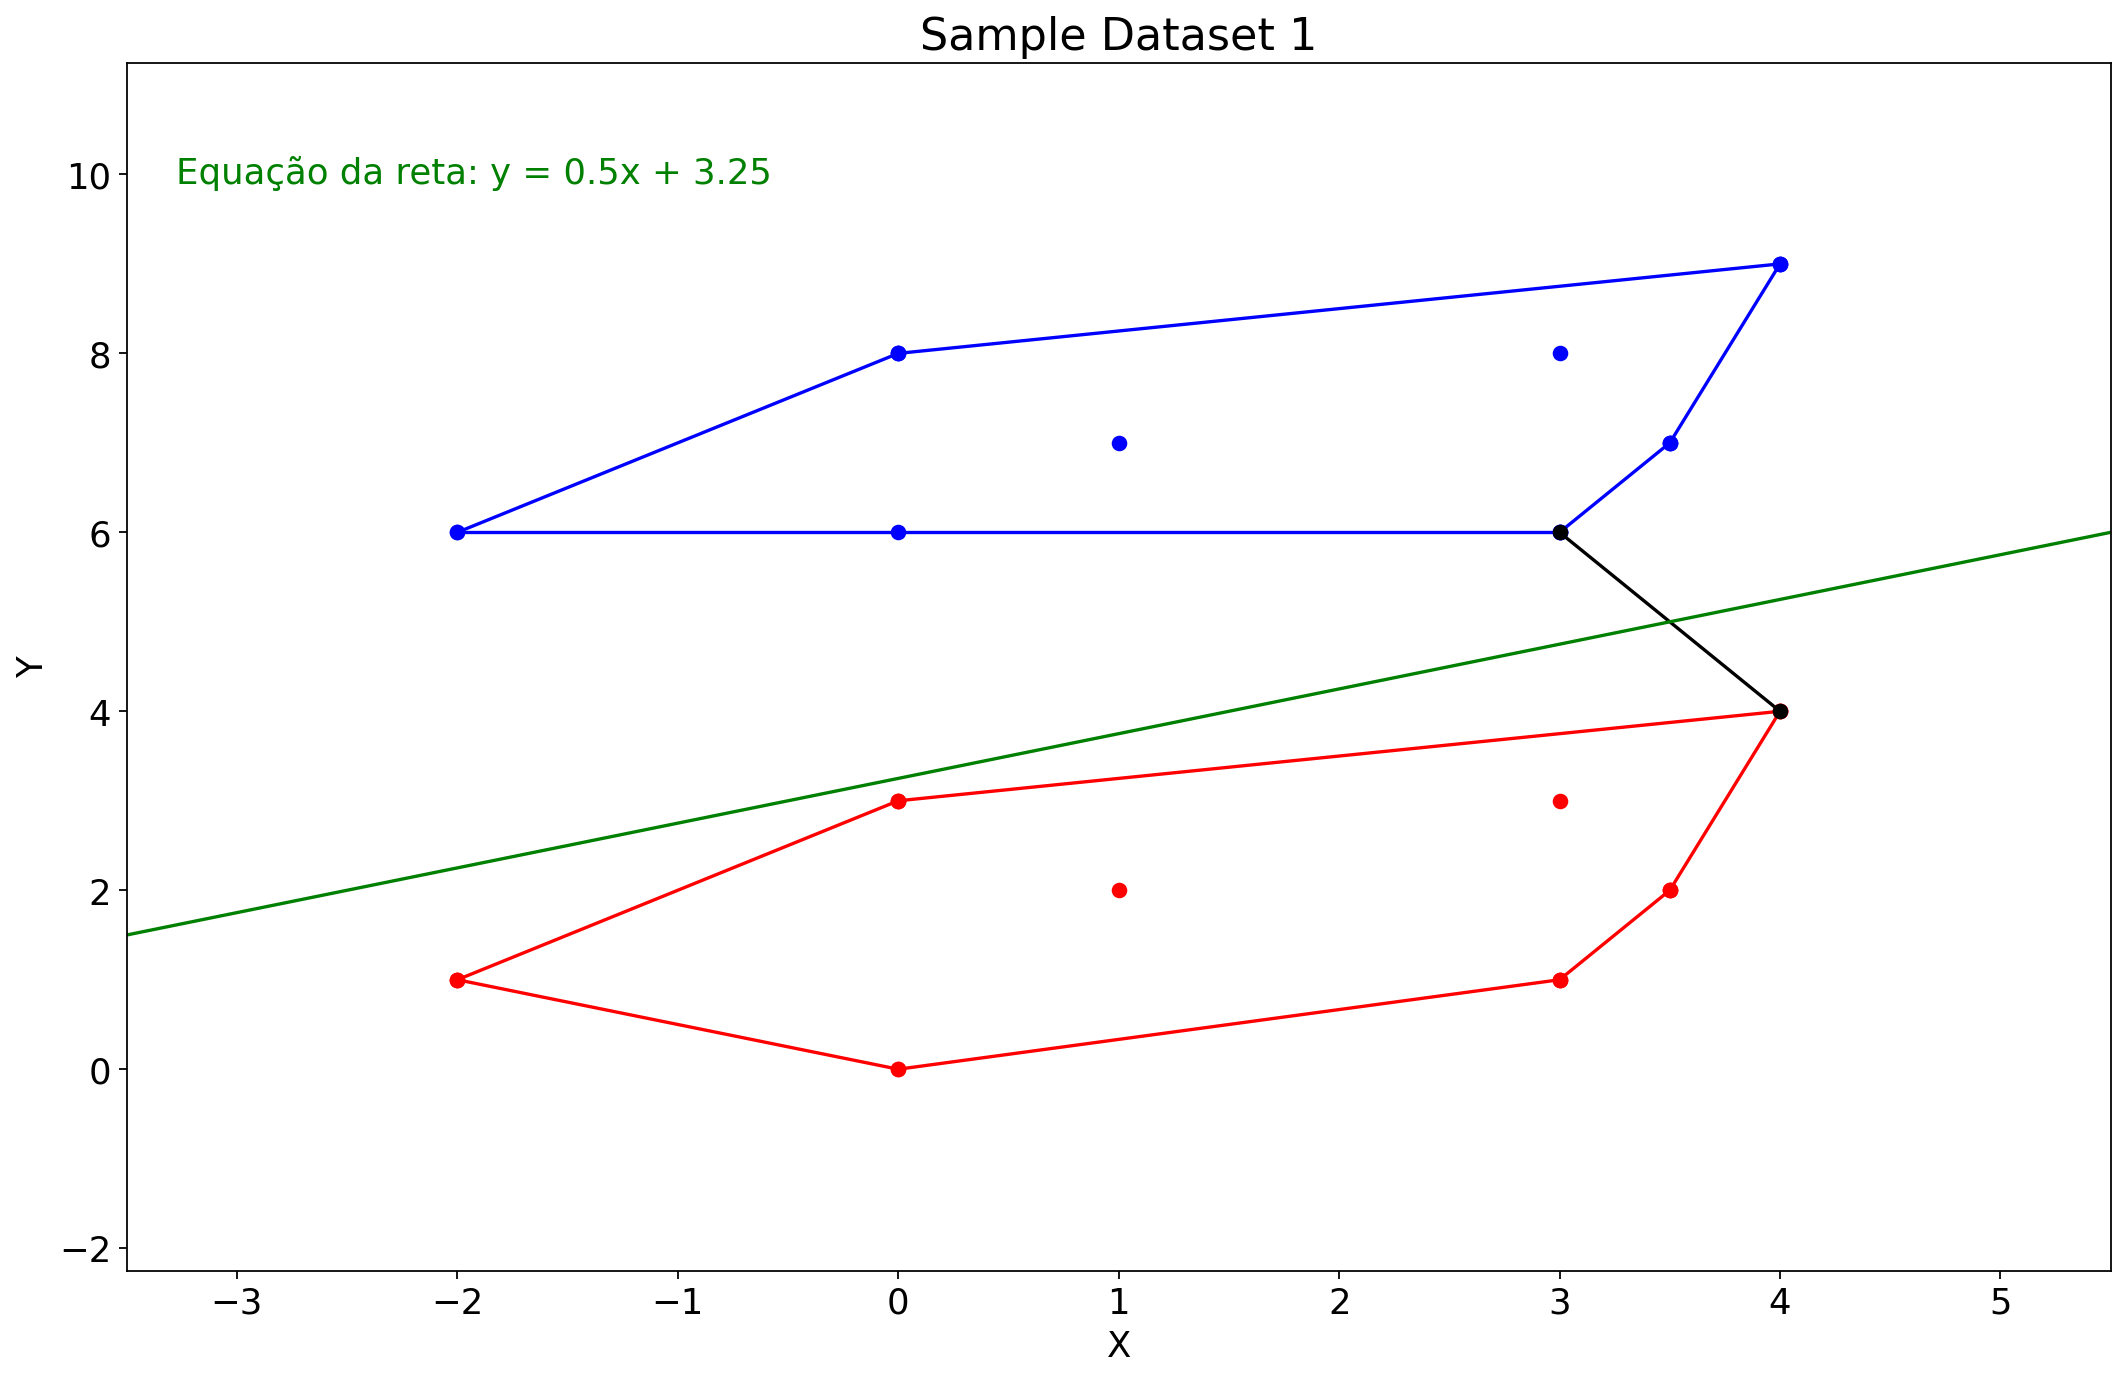

In [99]:
samplePoints1 = {  
    'X': [0, 1, 4, 0, 3, 3, 3.5, -2, 0, 1, 4, 0, 3, 3, 3.5, -2], 
    'Y': [3, 2, 4, 0, 1, 3, 2, 1, 8, 7, 9, 6, 6, 8, 7, 6],
    'Class': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
}

sample1 = pd.DataFrame(samplePoints1)

findAndPlotModel(sample1, "Sample Dataset 1")

In [100]:
evaluateModel(sample1)

Avaliação do modelo:
Fold: 1
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 2
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 3
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 4
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 5
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0


<ipython-input-90-14a5b8e4f956>:4: RuntimeWarning: divide by zero encountered in true_divide
  slope = (convexHull[i+1].y - convexHull[i].y)/(convexHull[i+1].x - convexHull[i].x)


As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.


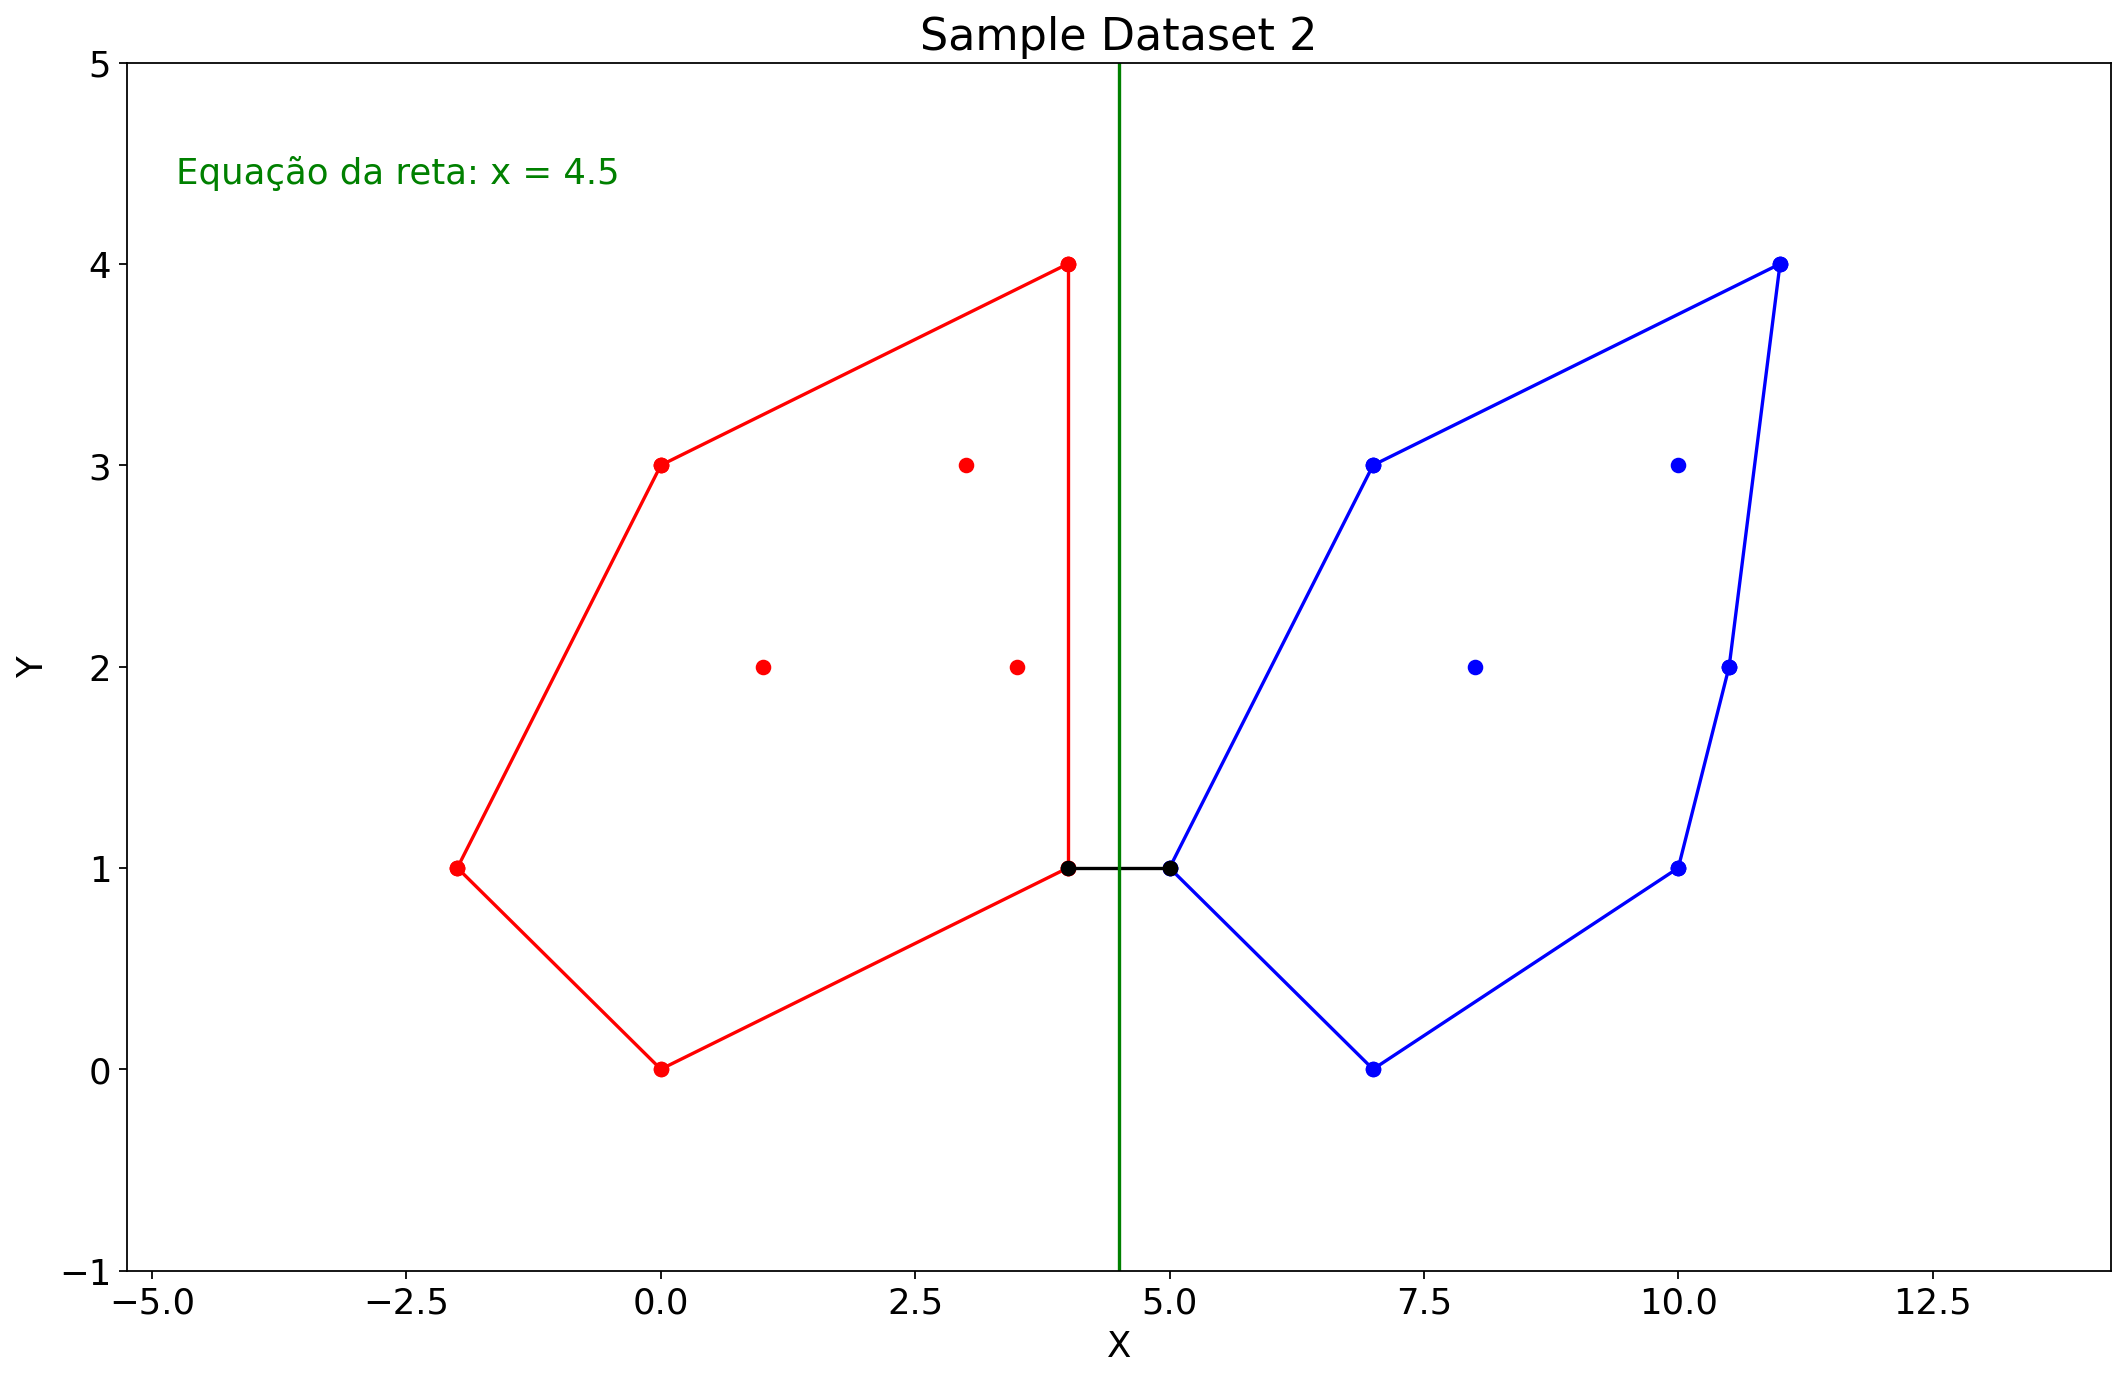

In [101]:
samplePoints2 = {
    'X': [0, 1, 4, 0, 4, 3, 3.5, -2, 7, 8, 11, 7, 10, 10, 10.5, 5],
    'Y': [3, 2, 4, 0, 1, 3, 2, 1, 3, 2, 4, 0, 1, 3, 2, 1],
    'Class': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
}

sample2 = pd.DataFrame(samplePoints2)

findAndPlotModel(sample2, "Sample Dataset 2")

In [102]:
evaluateModel(sample2)

Avaliação do modelo:
Fold: 1
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 2
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 3
	Precisão: 0.3333333333333333
	Revocação: 0.3333333333333333
	F-Score: 0.3333333333333333
Fold: 4
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 5
	Precisão: 0.3333333333333333
	Revocação: 0.3333333333333333
	F-Score: 0.3333333333333333


Experimento Banana

As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.


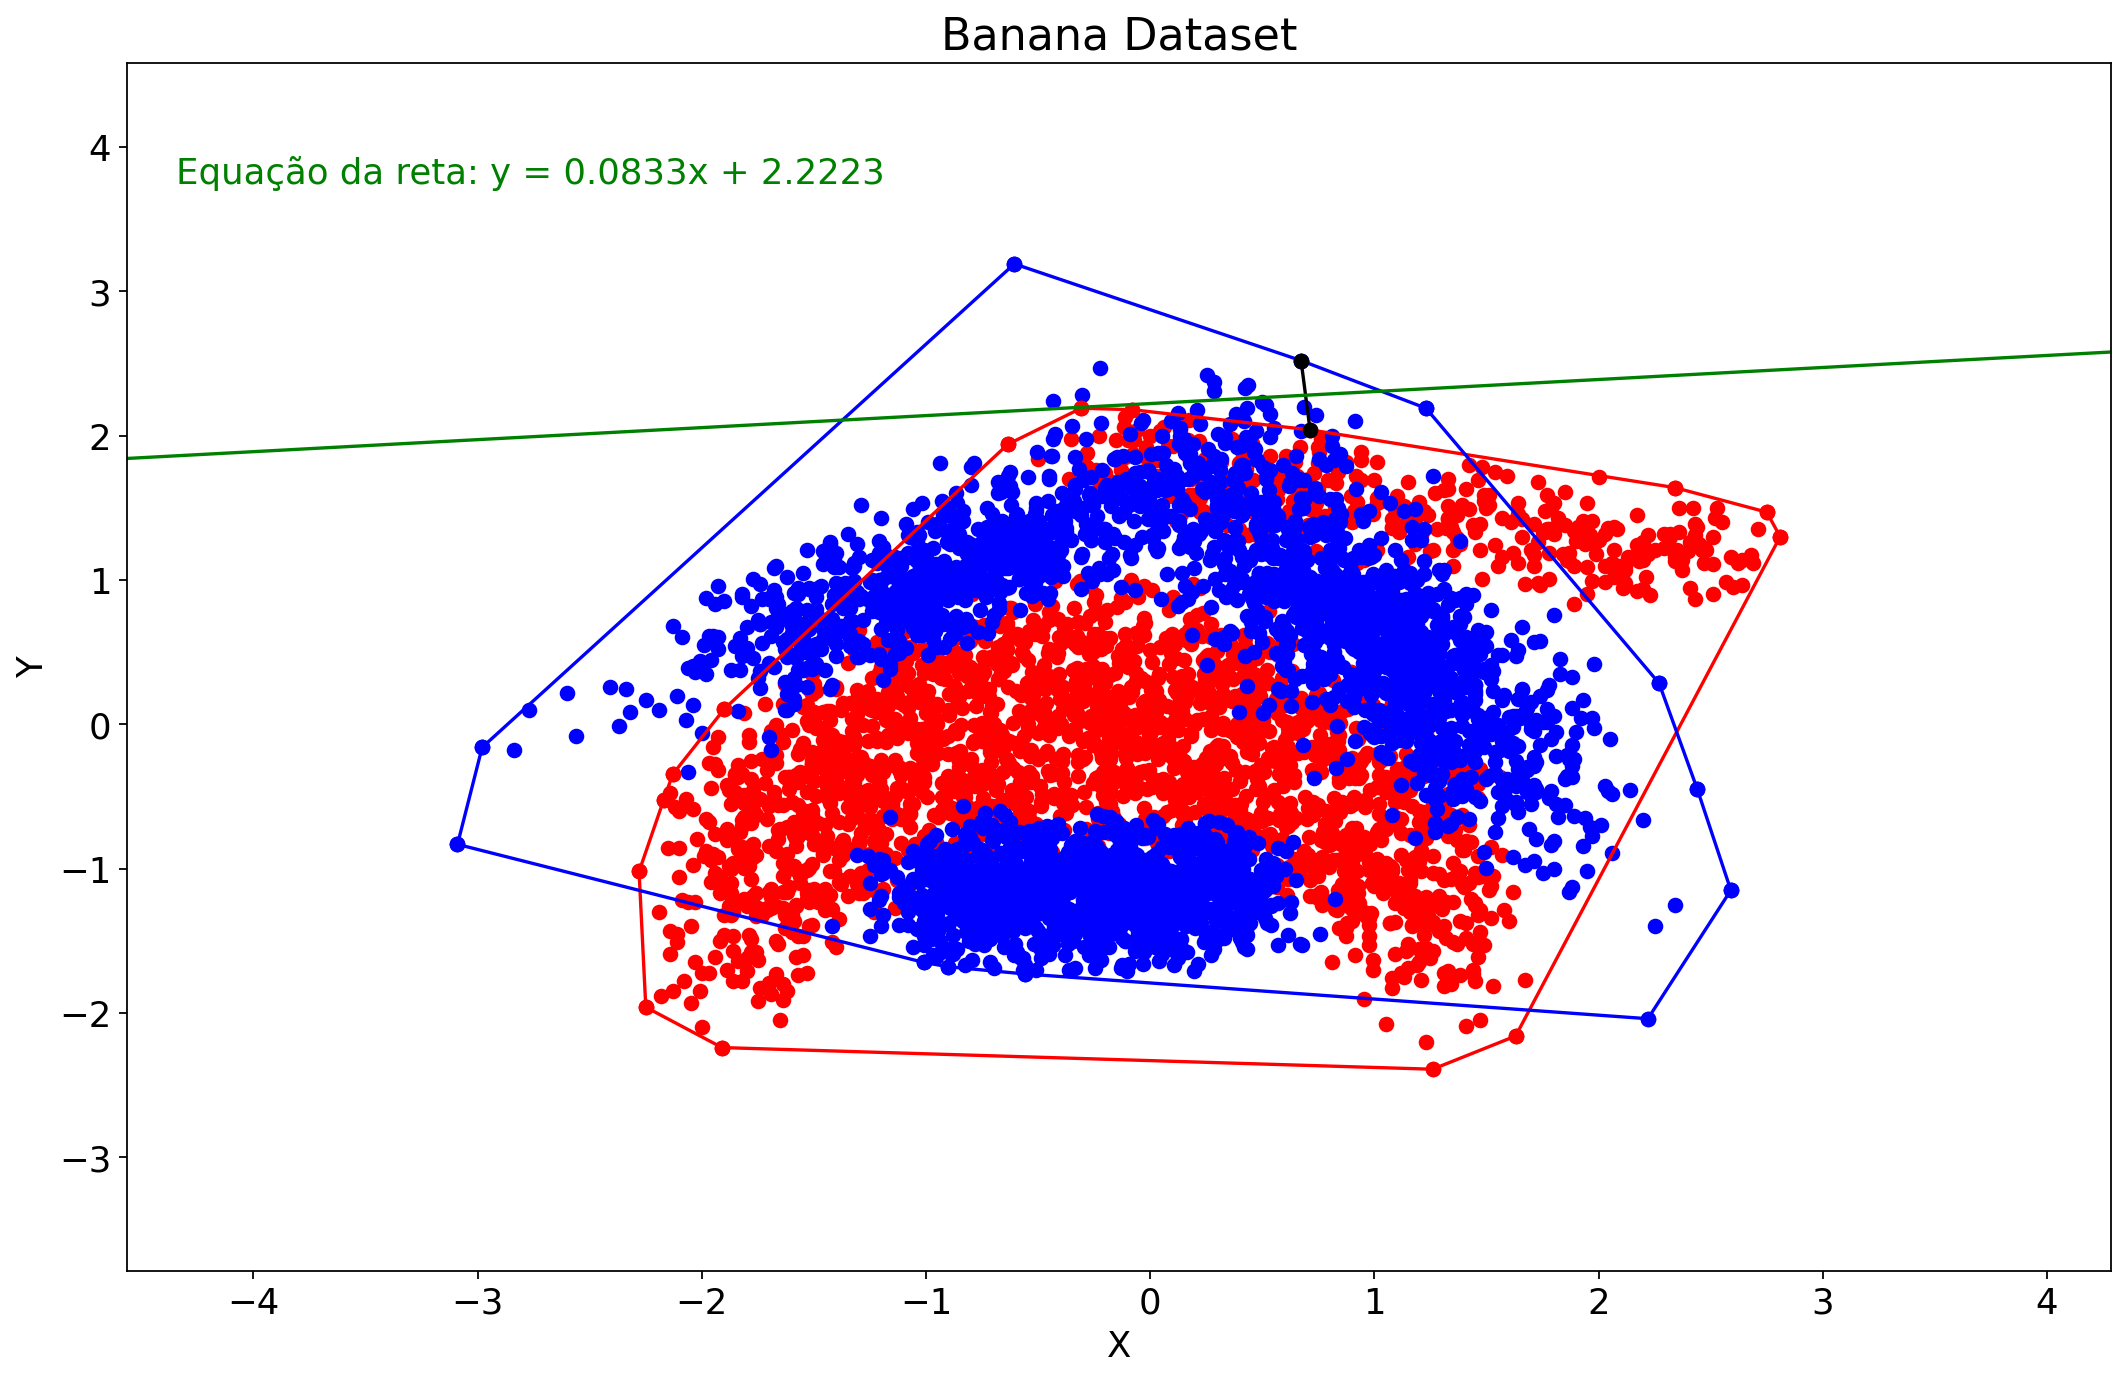

In [103]:
banana = readDatFile('datFiles/banana.dat', ',')

banana = banana.replace({'Class': {-1.0: 0, 1.0: 1}})

findAndPlotModel(banana, "Banana Dataset")


In [104]:
evaluateModel(banana)

Avaliação do modelo:
Fold: 1
	Precisão: 0.5509433962264151
	Revocação: 0.5509433962264151
	F-Score: 0.5509433962264151
Fold: 2
	Precisão: 0.5660377358490566
	Revocação: 0.5660377358490566
	F-Score: 0.5660377358490566
Fold: 3
	Precisão: 0.5471698113207547
	Revocação: 0.5471698113207547
	F-Score: 0.5471698113207547
Fold: 4
	Precisão: 0.55
	Revocação: 0.55
	F-Score: 0.55
Fold: 5
	Precisão: 0.559433962264151
	Revocação: 0.559433962264151
	F-Score: 0.559433962264151


Experimento Iris

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.


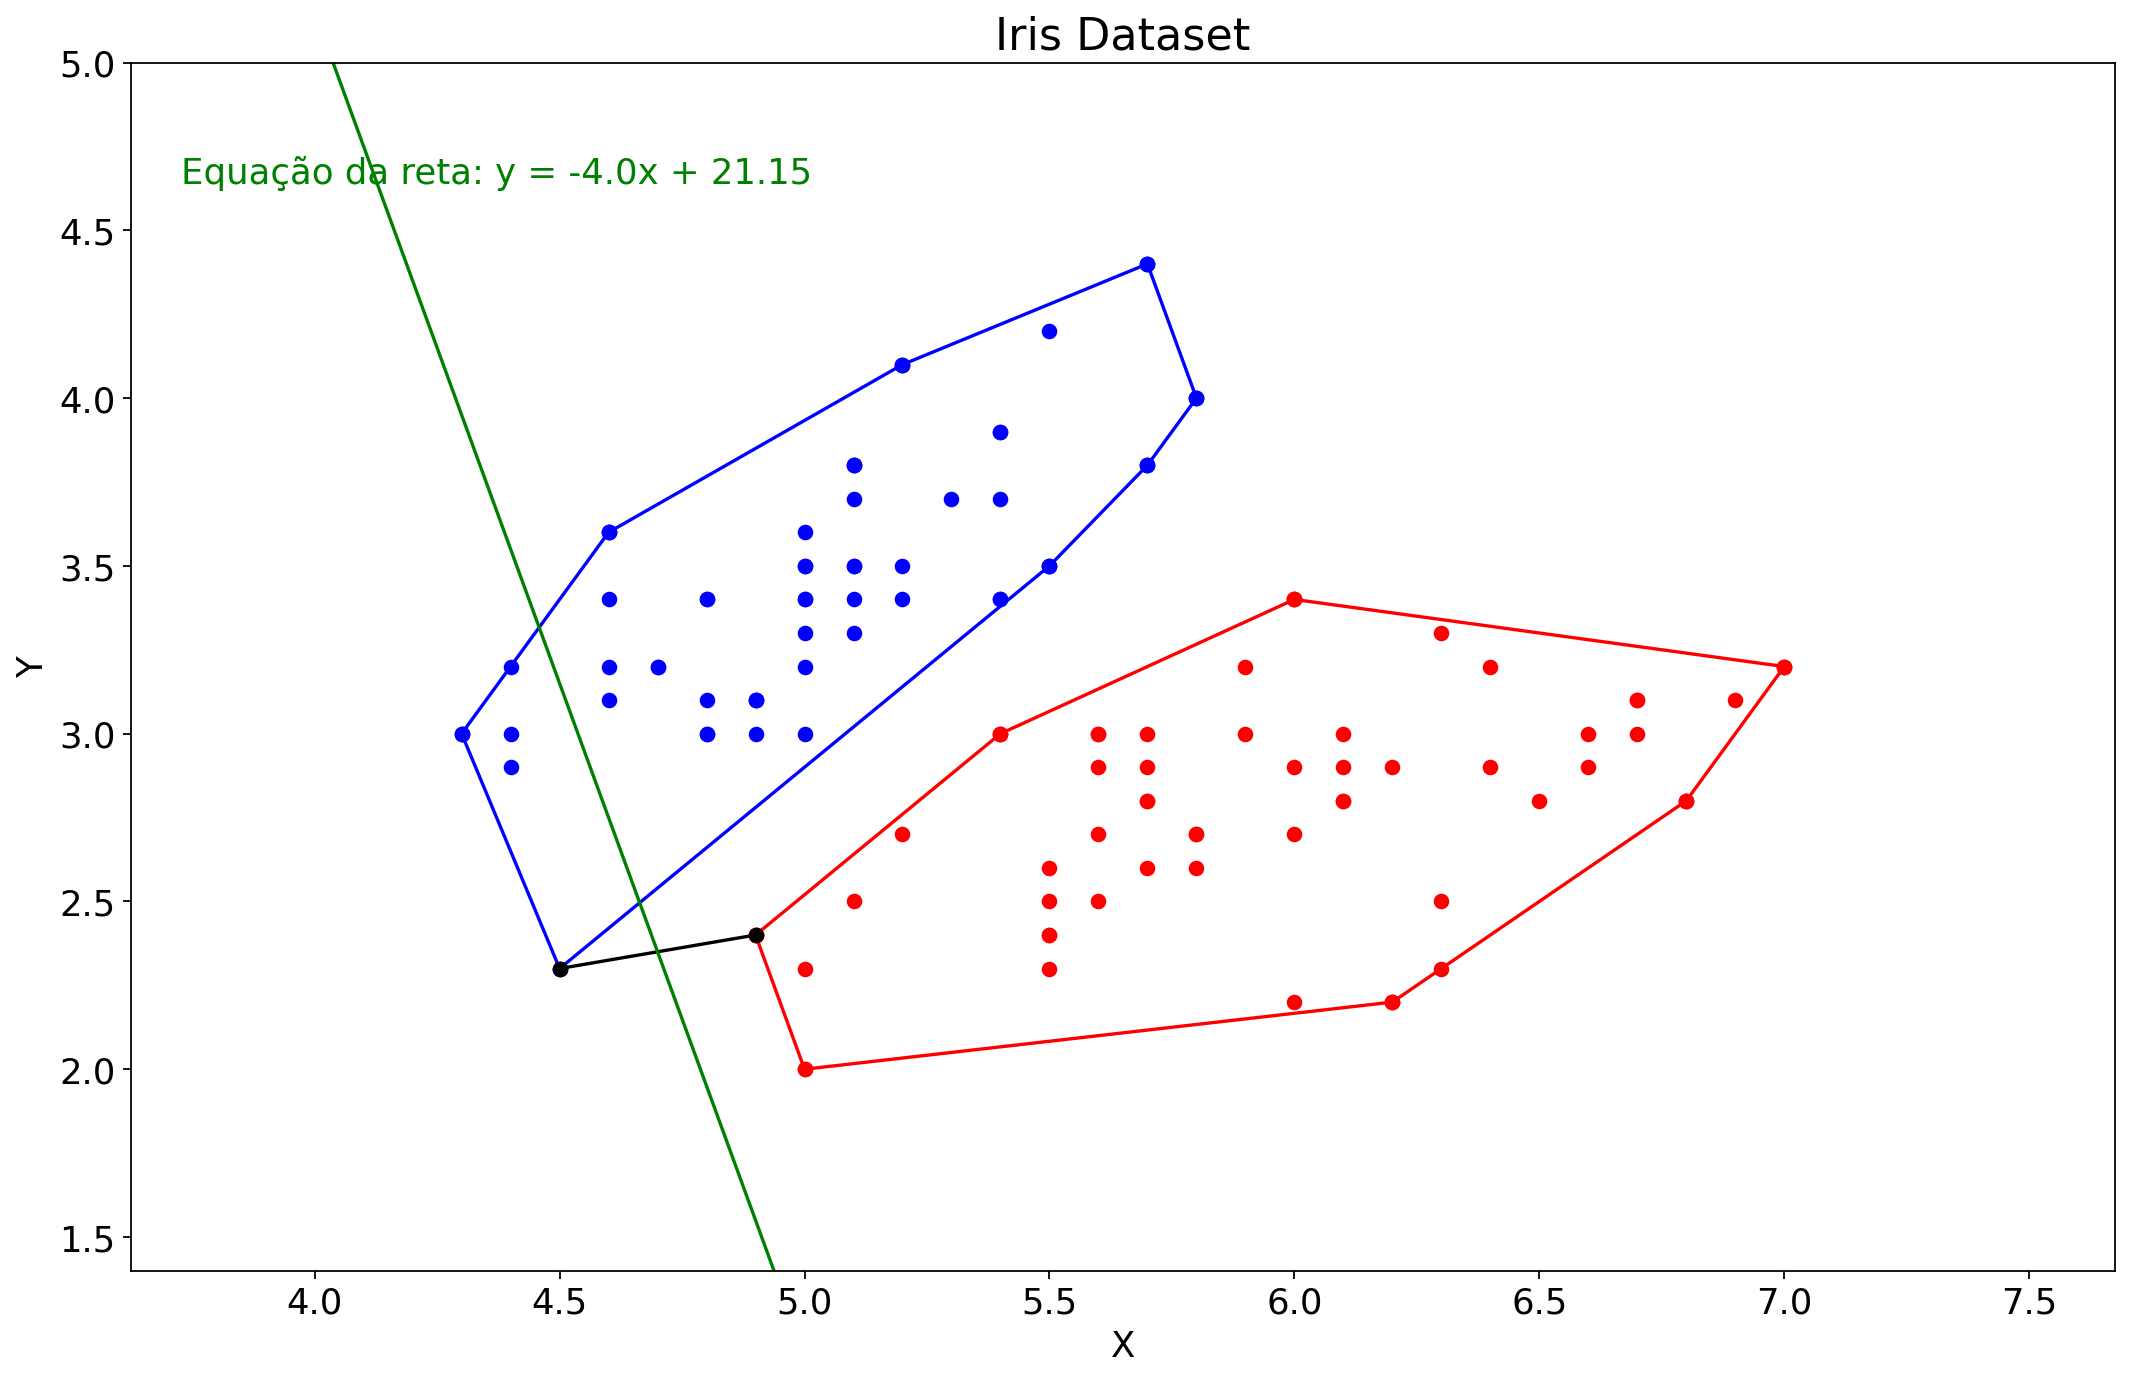

In [105]:
iris = readDatFile('datFiles/iris.dat', ', ')

iris = iris.replace({'Class': {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}})
iris = iris[iris['Class'] != 2]
iris = pd.DataFrame({'X': iris['SepalLength'], 'Y': iris['SepalWidth'], 'Class': iris['Class']})

findAndPlotModel(iris, "Iris Dataset")

In [106]:
evaluateModel(iris)

Avaliação do modelo:
Fold: 1
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 2
	Precisão: 0.55
	Revocação: 0.55
	F-Score: 0.55
Fold: 3
	Precisão: 0.5
	Revocação: 0.5
	F-Score: 0.5
Fold: 4
	Precisão: 0.05
	Revocação: 0.05
	F-Score: 0.05000000000000001
Fold: 5
	Precisão: 0.55
	Revocação: 0.55
	F-Score: 0.55


Experimento Anel

As envoltórias convexas se sobrepõem, portanto, os conjuntos não são linearmente separáveis.


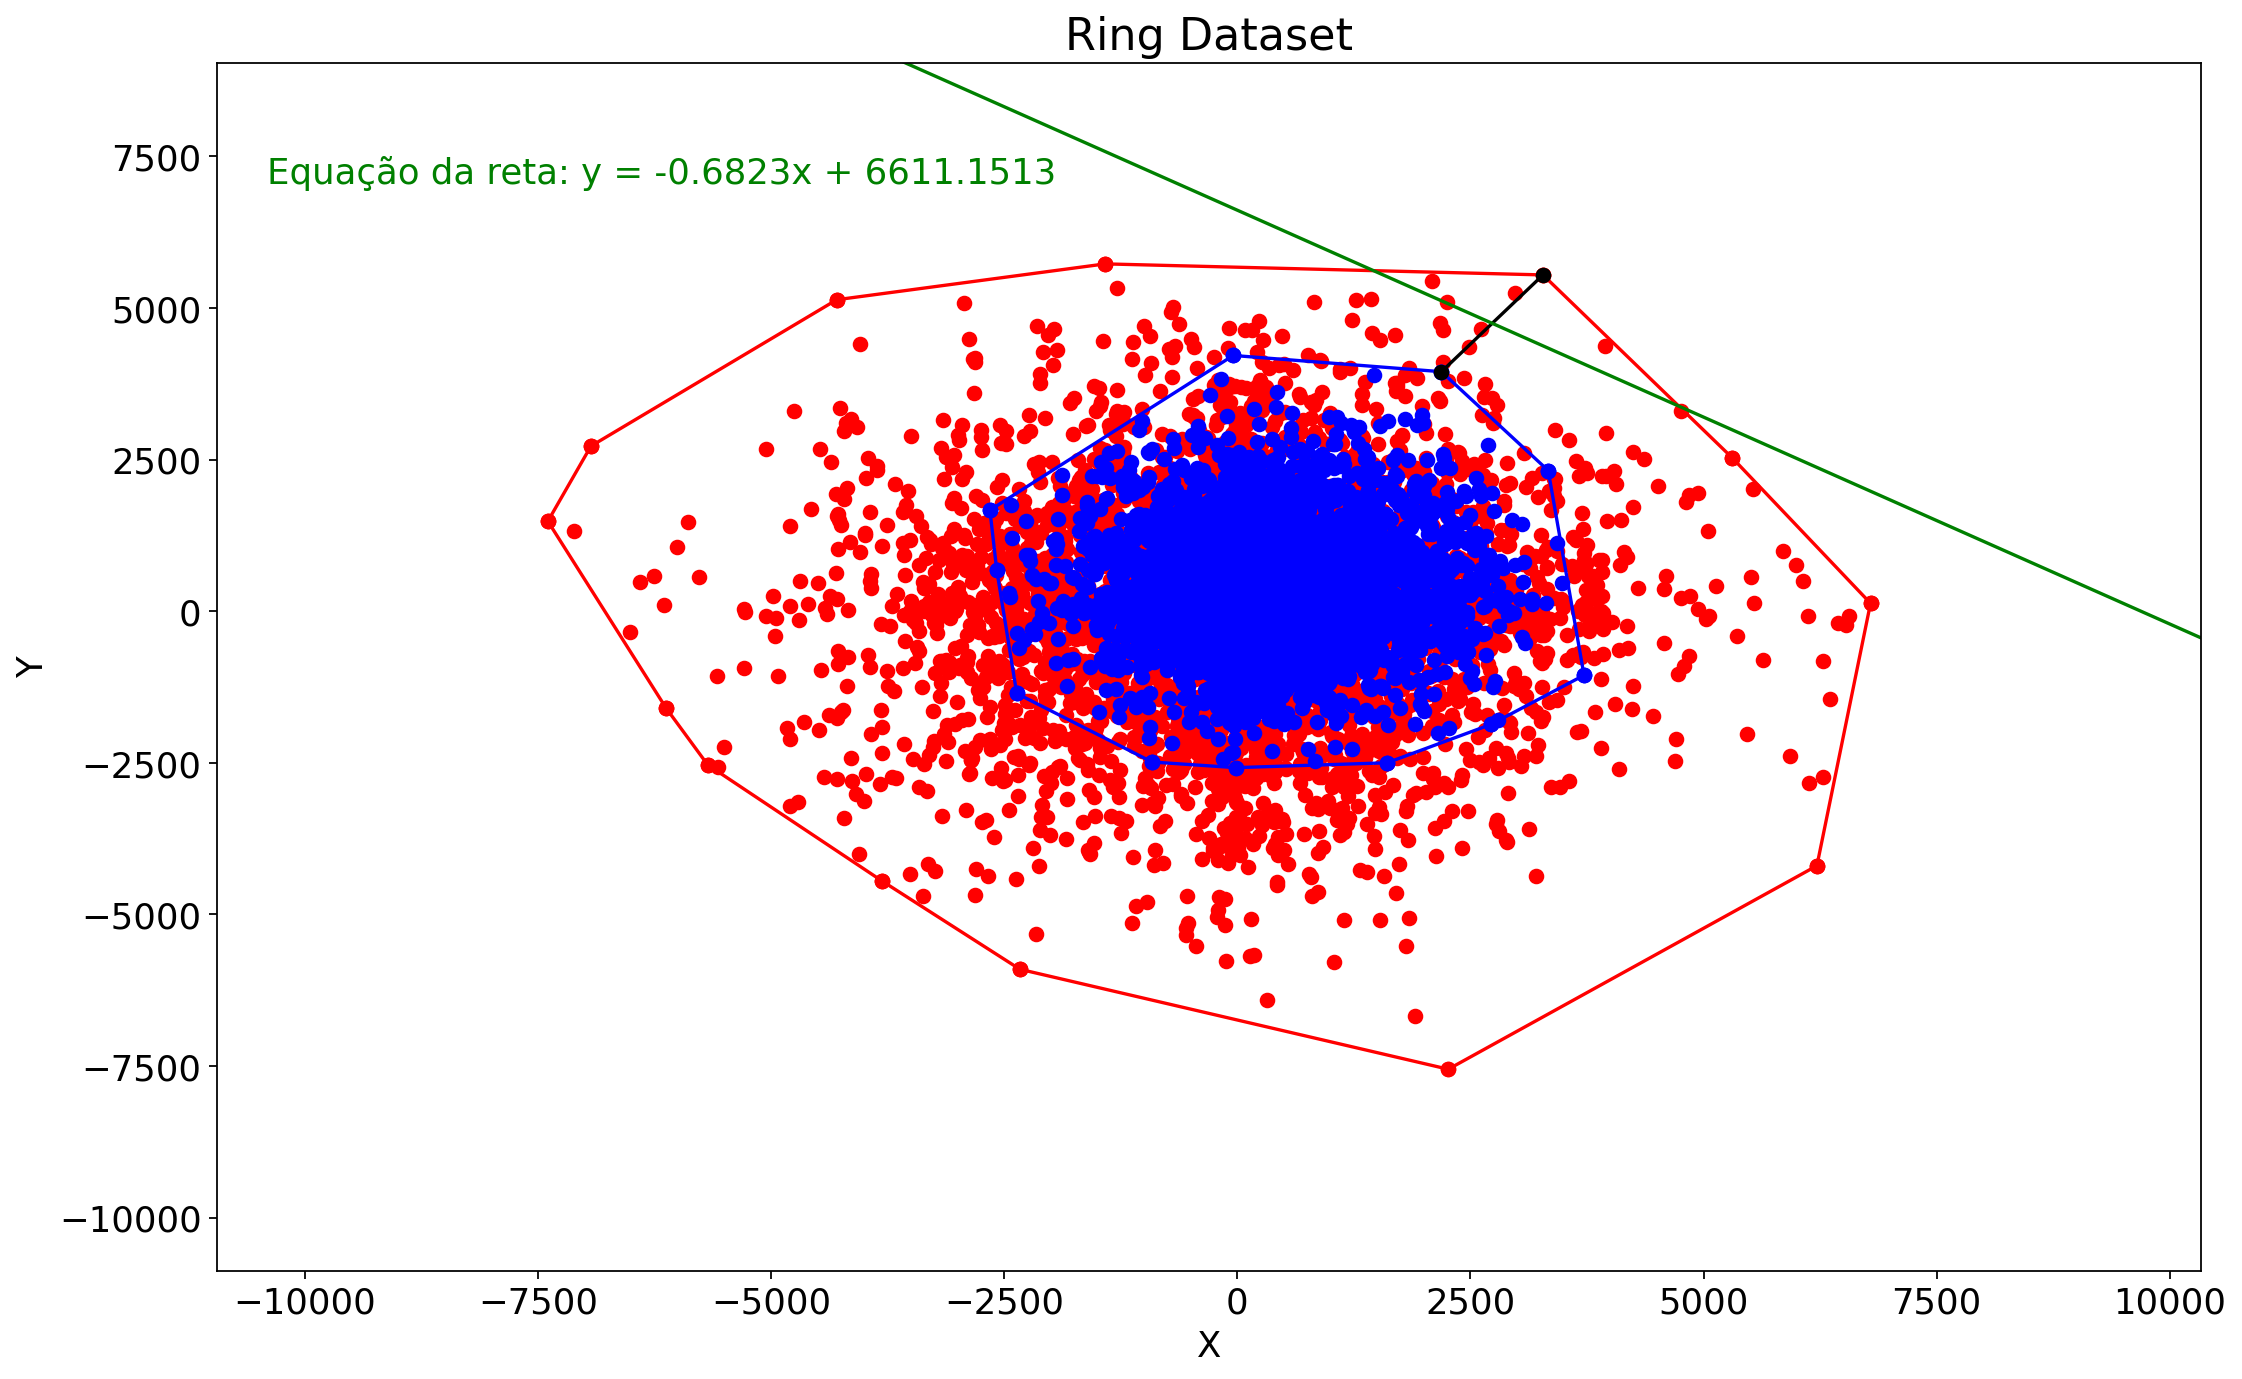

In [107]:
ring = readDatFile('datFiles/ring.dat', ', ')

ring = pd.DataFrame({'X': ring['A12'], 'Y': ring['A19'], 'Class': ring['Class']})

findAndPlotModel(ring, "Ring Dataset")

In [108]:
evaluateModel(ring)

Avaliação do modelo:
Fold: 1
	Precisão: 0.4885135135135135
	Revocação: 0.4885135135135135
	F-Score: 0.4885135135135135
Fold: 2
	Precisão: 0.49527027027027026
	Revocação: 0.49527027027027026
	F-Score: 0.49527027027027026
Fold: 3
	Precisão: 0.4918918918918919
	Revocação: 0.4918918918918919
	F-Score: 0.4918918918918919
Fold: 4
	Precisão: 0.4945945945945946
	Revocação: 0.4945945945945946
	F-Score: 0.4945945945945946
Fold: 5
	Precisão: 0.4905405405405405
	Revocação: 0.4905405405405405
	F-Score: 0.4905405405405406
